# Foundations Of AIML
## Session 11
### Experiment 3.1: Supervision from web data

In [2]:
import config as cf
import cv2
import matplotlib.pyplot as plt

Tons of data area available on the web (wikipedia, Google, Twitter, YouTube) that could be used to train an ML model.
One such source is Google Images. You enter a text query and Google Images shows thousands of related images based on the query and text that are present on the web page with the related image.

In this experiment we would crawl images from Google Images and try to use this as data for training.

1. Your task is to search for face images for 'AamairKhan', 'Rimisen', 'Kajol', 'KareenaKapoor','RishiKapoor', 'AmrishPuri', 'AnilKapoor', 'AnupamKher', 'BomanIrani', 'HrithikRoshan', 'KajalAgarwal', 'KatrinaKaif', 'Madhavan', 'MadhuriDixit', 'Umashri', 'Trisha'

2. Refine your search to faces (Google Images -> enter query -> Tools -> Type -> Face). You could also use movies', ads' names as additional query (e.g., "Aamir 3 idiots", "Boman Irani Khosla Ka Ghosla", "Katrina Slice ad" etc.). The results are noisy but they are useful, and moreover, they are avaible in abundance and for free!

    a. Example: https://www.google.co.in/search?client=firefox-b-ab&dcr=0&biw=1366&bih=628&tbs=itp%3Aface&tbm=isch&sa=1&ei=5gbIWtCjN4n2vgSCoqzYBw&q=biswa+kalyan+rath

3. Then use a browser extensions to download all the results into a directory. In this way you, would get around 300-600 images for each class. Overall, you should collect atleast 10000 images.
    
    a. Firefox: https://addons.mozilla.org/en-US/firefox/addon/google-images-downloader/
    
    b. Chrome: https://chrome.google.com/webstore/detail/download-all-images/ifipmflagepipjokmbdecpmjbibjnakm/related?hl=en
    
4. **Without cleaning** use these images as your training data. Test you results on IMFDB test set.



We have provided an example of this process for a toy dataset: Indian Internet Celebrity. It consists of 5 celebrities: 'baba_ramdev', 'biswa',  'dhinchak_pooja',  'khali', and 'priya_prakash'

As described above, we obtained around 200 images for each class and randomly set aside 10 images per class (Total 50 images) as test images.

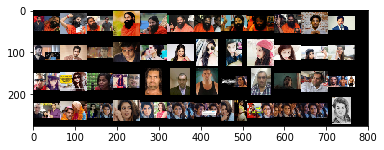

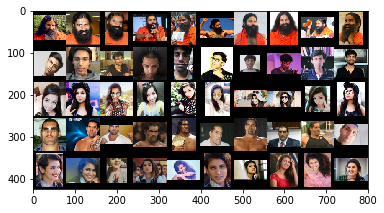

In [4]:
cf.data_dir = 'data/'
plt.imshow(cv2.imread(cf.data_dir+'IIC/train.png')[:,:,::-1])   ### training images examples
plt.show()
plt.imshow(cv2.imread(cf.data_dir+'IIC/test.png')[:,:,::-1])   ### training images examples
plt.show()

Create a list file of all training images with this shell command (assuming following directory structure):
```console
>ls
baba_ramdev  biswa  dhinchak_pooja  khali  priya_prakash

>ls dhinchak_pooja/ 
test  train

> ls dhinchak_pooja/train/
100.jpg   116.jpg   134.jpg  15.jpeg   164.jpg	 182.jpg   20.jpeg  217.jpg  234.jpg   250.jpeg  266.jpg  309.png  45.jpg  61.jpg  77.jpg  94.jpg ...............

> for f in *; do for g in $f/train/*; do echo $g; done; done > train.txt
```


Create a list file of all test images with this shell command

```console
> for f in *; do for g in $f/test/*; do echo $g; done; done > test.txt
```

Once you have the data, we can train/ fine-tune a network. Let's try doing prediction of Indian Internet Celebrity from noisy web data.

In [6]:
# Importing pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
# Importing config.py file
import config as cf
from utils import *
from light_cnn import network_9layers
#from resnet import resnet18
from data_loader import *
from contrastive import *   ### implementation of contrastive loss
## Importing python packages
import os
import sys
import time
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt

In [8]:
img_root = cf.data_dir+'IIC/'

train_list_file = cf.data_dir+'IIC_train.txt'   #### 5000 images for training
val_list_file = cf.data_dir+'IIC_test.txt'      #### 1095 images for validation


train_image_list = [line.rstrip('\n') for line in open(train_list_file)]
val_image_list = [line.rstrip('\n') for line in open(val_list_file)]

print (len(train_image_list), len(val_image_list))

### Notice a new data loader for siamese networks. This gives the image pairs (image_1, image_2) and a label as input to the siamese networks.
### see siamese_data_loader.py for details

trainloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = train_list_file, crop=False,
                                                             resize = True, resize_shape=[128,128], classes = 'IIC'), 
                                           batch_size=8, num_workers=8, shuffle = True, pin_memory=True)

testloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = val_list_file, crop=False, mirror=False, 
                                                           resize = True, resize_shape=[128,128], classes = 'IIC'), 
                                           batch_size=10, num_workers=5, shuffle = False, pin_memory=True)

classes = ['baba_ramdev', 'biswa',  'dhinchak_pooja',  'khali',  'priya_prakash']

1003 50


In [10]:
# Checking for GPU instance
use_cuda = torch.cuda.is_available()
#Intilizaing the accuracy value as zero
best_acc = 0
num_classes = 5
print(use_cuda)

False


In [12]:
feature_net = network_9layers()   ### creates an object of this network architecture
from collections import OrderedDict
new_state_dict = OrderedDict()
#state_dict = torch.load(cf.data_dir+'light_cnn/LightCNN_9Layers_checkpoint.pth.tar')['state_dict']    ### load the learned lightCNN weights
state_dict = torch.load(cf.data_dir+'light_cnn/LightCNN_9Layers_checkpoint.pth.tar',map_location=lambda storage, loc: storage)['state_dict']
for k, v in state_dict.items():
    name = k[7:] 
    new_state_dict[name] = v

feature_net.load_state_dict(new_state_dict)

### starting the surgery
layers_to_remove = ['fc2']
for layers_ in layers_to_remove:        
    del(feature_net._modules[layers_])
    
#### old fc2 removed.

classifier = nn.Sequential(nn.Linear(256, 64), nn.BatchNorm1d(64), nn.ReLU(),
                           nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(),
                           nn.Linear(32, num_classes))

### implanting a new fc2
feature_net.fc2 = classifier
if use_cuda:
    feature_net.cuda()
    


In [13]:
criterion = nn.CrossEntropyLoss()

In [14]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    feature_net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = feature_net(inputs)      ### notice that the pre-trained network has an implant classifier which directly outputs the 16 class prediction scores

        
        size_ = outputs.size()
        outputs_ = outputs.view(size_[0], num_classes)
        loss = criterion(outputs_, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.data[0]
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        if batch_idx%10 == 0 or batch_idx == len(trainloader)-1:
            progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    train_loss_file.write('%d %.3f %.3f\n' %(epoch, train_loss/len(trainloader), 100.*correct/total))



In [16]:
def test(epoch):
    global best_acc
    feature_net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = feature_net(inputs)
        size_ = outputs.size()
        outputs_ = outputs.view(size_[0], num_classes)
        loss = criterion(outputs_, targets)

        test_loss += loss.data[0]
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        if batch_idx%10 == 0 or batch_idx == len(testloader)-1:
            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    print ('val_loss: ',  test_loss/len(testloader), 'accuracy: ', 100.0*correct/total)
    val_loss_file.write('%d %.3f %.3f\n' %(epoch,  test_loss/len(testloader), 100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': classifier,
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir(cf.data_dir+'checkpoint'):
            os.mkdir(cf.data_dir+'checkpoint')
        torch.save(state, cf.data_dir+'checkpoint/checkpoint_ckpt.t7')
        best_acc = acc
    
    return test_loss/len(testloader)

In [22]:
experiment = 'lightnet_finetune_fc_IIC/'
# train_loss_file = open(cf.data_dir+experiment+"train_loss.txt", "w", 0)
# val_loss_file = open(cf.data_dir+experiment+"val_loss.txt", "w", 0)
train_loss_file = open(cf.data_dir+experiment+"train_loss.txt", "w+")
val_loss_file = open(cf.data_dir+experiment+"val_loss.txt", "w+")

In [23]:
layers_to_finetune = [{'params': feature_net.features.parameters()}, 
                      {'params': feature_net.fc1.parameters()},
                      {'params':feature_net.fc2.parameters()}]

In [24]:
best_acc = 0
optimizer = optim.Adam(layers_to_finetune, lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)   #### dynamic LR scheduler
for epoch in range(0, 30):
    train(epoch)
    test_loss = test(epoch)
    scheduler.step(test_loss)
    
train_loss_file.close()
val_loss_file.close()


Epoch: 0


C:\Users\vgopired\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


KeyboardInterrupt: 

30 30


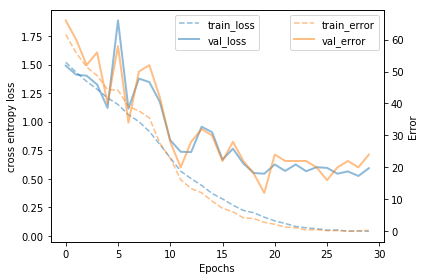

In [12]:
training_curves(cf.data_dir+experiment)

In [13]:
classifier = torch.load(cf.data_dir+'checkpoint/checkpoint_ckpt.t7')['net'].eval()

In [16]:
def eval():
    feature_net.eval()
    
    testloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = val_list_file, crop=False, mirror=False, 
                                                           resize = True, resize_shape=[128,128], classes='IIC'), 
                                           batch_size=1, num_workers=1, shuffle = False, pin_memory=True)
    correct = 0
    total = 0
    conf_mat = np.zeros((num_classes, num_classes))
    total_ = np.zeros((num_classes))
    wrong_predictions = []
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = feature_net(inputs)
        size_ = outputs.size()
        outputs_ = outputs.view(size_[0], num_classes)
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        prediction = predicted.cpu().numpy()[0]
        targets = targets.data.cpu().numpy()[0]
        total_[targets] +=1
        conf_mat[predicted, targets] +=1
        
        if prediction != targets:
            wrong_predictions += [[inputs, prediction, targets]]
        
    for k in range(num_classes):
        conf_mat[:,k] /= total_[k]
    return conf_mat, 100.*correct/total, wrong_predictions
    

In [17]:
conf, acc, wrong_predictions = eval()
print 'Accuracy:', acc, '%'

Accuracy: 76.0 %


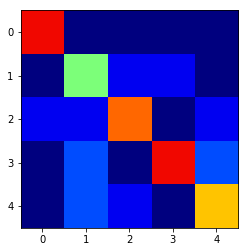

In [18]:
plt.imshow(conf, cmap='jet', vmin=0, vmax = 1)
plt.show()

baba_ramdev confused with dhinchak_pooja


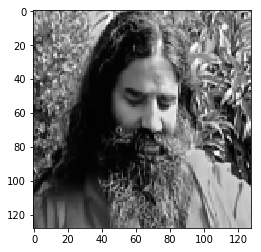

biswa confused with dhinchak_pooja


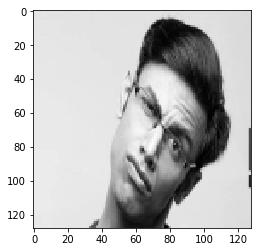

biswa confused with priya_prakash


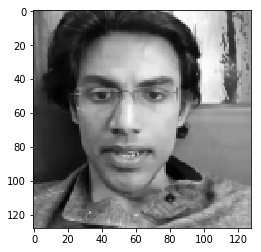

biswa confused with priya_prakash


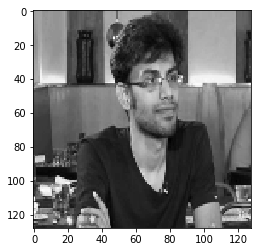

biswa confused with khali


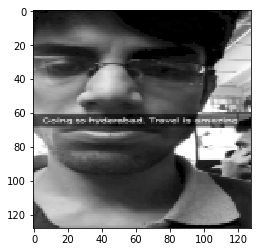

biswa confused with khali


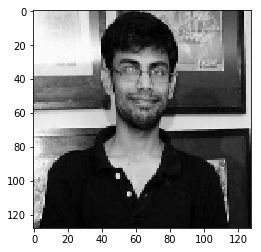

dhinchak_pooja confused with biswa


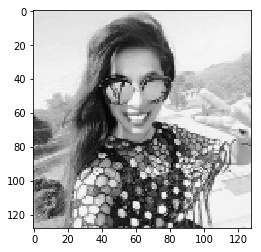

dhinchak_pooja confused with priya_prakash


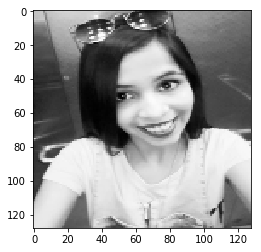

khali confused with biswa


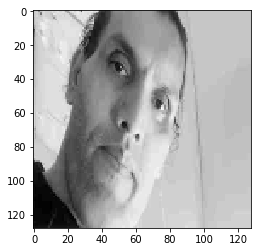

priya_prakash confused with khali


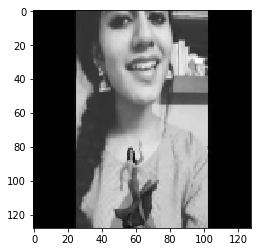

priya_prakash confused with khali


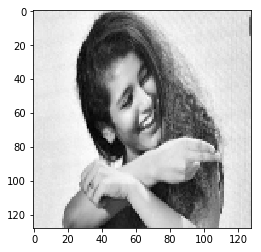

priya_prakash confused with dhinchak_pooja


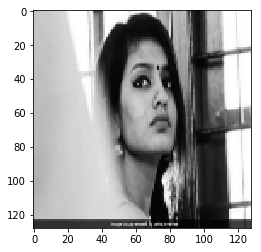

In [19]:
for w in wrong_predictions:
    print classes[w[2]], 'confused with', classes[w[1]]
    plt.imshow(w[0][0][0].data.cpu().numpy(), cmap='gray')
    plt.show()

Note that, this is the performance obtained from just 10 minutes of data collection.

Now repeat this experiment with the classes from IMFDB 16. Note that training set is the new set that you have crawled from the web and the test set is at cf.data_dir+'IMFDB_test.txt'

In [ ]:
img_root = cf.data_dir+'YOUR_TRAIN_DATA_ROOT_DIR/'    #### replace this string with your training directory root

train_list_file = cf.data_dir+'YOUR_TRAINING_IMAGES_LIST.txt'   #### list of (atleast) 10000 images that you have collected from the web
val_list_file = cf.data_dir+'IMFDB_test.txt'      #### 1095 images for validation


train_image_list = [line.rstrip('\n') for line in open(train_list_file)]
val_image_list = [line.rstrip('\n') for line in open(val_list_file)]

print len(train_image_list), len(val_image_list)

trainloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = train_list_file, crop=False,
                                                             resize = True, resize_shape=[128,128]), 
                                          batch_size=32, num_workers=16, shuffle = True, pin_memory=True)

testloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = val_list_file, crop=False, mirror=False, 
                                                           resize = True, resize_shape=[128,128]), 
                                         batch_size=10, num_workers=5, shuffle = False, pin_memory=True)

classes = ['AamairKhan', 'Rimisen', 'Kajol', 'KareenaKapoor','RishiKapoor', 'AmrishPuri', 'AnilKapoor', 'AnupamKher', 'BomanIrani', 'HrithikRoshan', 'KajalAgarwal', 'KatrinaKaif', 'Madhavan', 'MadhuriDixit', 'Umashri', 'Trisha']

In [ ]:
best_acc = 0
num_classes = 16

In [ ]:
feature_net = network_9layers()   ### creates an object of this network architecture
from collections import OrderedDict
new_state_dict = OrderedDict()
state_dict = torch.load(cf.data_dir+'light_cnn/LightCNN_9Layers_checkpoint.pth.tar')['state_dict']    ### load the learned lightCNN weights
for k, v in state_dict.items():
    name = k[7:] 
    new_state_dict[name] = v

feature_net.load_state_dict(new_state_dict)

### starting the surgery
layers_to_remove = ['fc2']
for layers_ in layers_to_remove:        
    del(feature_net._modules[layers_])
    
#### old fc2 removed.

classifier = nn.Sequential(nn.Linear(256, 64), nn.BatchNorm1d(64), nn.ReLU(),
                           nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(),
                           nn.Linear(32, num_classes))

### implanting a new fc2
feature_net.fc2 = classifier
if use_cuda:
    feature_net.cuda()

In [ ]:
experiment = 'lightnet_finetune_WEBIMFDB'
train_loss_file = open(cf.data_dir+experiment+"train_loss.txt", "w", 0)
val_loss_file = open(cf.data_dir+experiment+"val_loss.txt", "w", 0)

In [ ]:
layers_to_finetune = [{'params': feature_net.features.parameters()}, 
                      {'params': feature_net.fc1.parameters()},
                      {'params':feature_net.fc2.parameters()}]

In [ ]:
best_acc = 0
optimizer = optim.Adam(layers_to_finetune, lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)   #### dynamic LR scheduler
for epoch in range(0, 30):
    train(epoch)
    test_loss = test(epoch)
    scheduler.step(test_loss)
    
train_loss_file.close()
val_loss_file.close()

In [ ]:
training_curves(cf.data_dir+experiment)

In [ ]:
classifier = torch.load(cf.data_dir+'checkpoint/checkpoint_ckpt.t7')['net'].eval()

In [ ]:
conf, acc, wrong_predictions = eval()
print 'Accuracy:', acc, '%'

In [ ]:
plt.imshow(conf, cmap='jet', vmin=0, vmax = 1)
plt.show()

In [ ]:
for w in wrong_predictions:
    print classes[w[2]], 'confused with', classes[w[1]]
    plt.imshow(w[0][0][0].data.cpu().numpy(), cmap='gray')
    plt.show()